# b-tagging Machine Learning Tutorial

training script for DL1

In [1]:
import h5py
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
from keras.layers import BatchNormalization
from keras.layers import Dense, Activation, Input, add
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback

Using TensorFlow backend.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from plottingFunctions import sigBkgEff

In [5]:
file_path = "/eos/home-m/mguth/public/btagging-ml_tutorial_files"

In [6]:
trainfile_name = file_path+"/MC16d_hybrid-training_sample-NN.h5"
h5f_train = h5py.File(trainfile_name, 'r')

In [7]:
X_train = h5f_train['X_train'][:]
Y_train = h5f_train['Y_train'][:]

In [8]:
testfile_name = file_path+"/MC16d_ttbar-test-validation_sample-NN.h5"
h5f_test = h5py.File(testfile_name, 'r')

In [9]:
X_test = h5f_test['X_test'][:]
Y_test = h5f_test['Y_test'][:]

In the following the DL1 network is defined

In [10]:
# Input layer
inputs = Input(shape=(X_train.shape[1],))
# number of nodes in the different hidden layers
l_units = [72, 57, 60, 48, 36, 24, 12, 6]
x = inputs
# loop to initialise the hidden layers
for unit in l_units:
    x = Dense(units=unit, activation="linear", kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x = Dropout(0.1)
# output layer, using softmax which will return a probability for each jet to be either light, c- or b-jet
predictions = Dense(units=3, activation='softmax',
                    kernel_initializer='glorot_uniform')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model_optimizer = Adam(lr=0.01)
model.compile(  # loss='mse',
    loss='categorical_crossentropy',
    optimizer=model_optimizer,
    metrics=['accuracy']
)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 72)                3240      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72)                288       
_________________________________________________________________
activation_1 (Activation)    (None, 72)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 57)                4161      
_________________________________________________________________
batch_normalization_2 (Batch (None, 57)                228       
_________________________________________________________________
acti

In [11]:
def GetRejection(y_pred, y_true):
    """Calculates the c and light rejection for 77% WP and 0.018 c-fraction."""
    b_index, c_index, u_index = 2, 1, 0
    cfrac = 0.018
    target_beff = 0.77
    y_true = np.argmax(y_true, axis=1)
    b_jets = y_pred[y_true == b_index]
    c_jets = y_pred[y_true == c_index]
    u_jets = y_pred[y_true == u_index]
    bscores = np.log(b_jets[:, b_index] / (cfrac * b_jets[:, c_index] +
                                           (1 - cfrac) * b_jets[:, u_index]))
    cutvalue = np.percentile(bscores, 100.0 * (1.0 - target_beff))

    c_eff = len(c_jets[np.log(c_jets[:, b_index] / (cfrac * c_jets[:, c_index]
                                                    + (1 - cfrac) *
                                                    c_jets[:, u_index])) >
                       cutvalue]) / float(len(c_jets))
    u_eff = len(u_jets[np.log(u_jets[:, b_index] / (cfrac *
                                                    u_jets[:, c_index] +
                                                    (1 - cfrac) *
                                                    u_jets[:, u_index])) >
                       cutvalue]) / float(len(u_jets))

    if c_eff == 0 or u_eff == 0:
        return -1, -1
    return 1. / c_eff, 1. / u_eff


class MyCallback(Callback):
    """Custom callback function calculating per epoch light and c-rejection and saves the model of each epoch."""
    def __init__(self, X_valid=0, Y_valid=0,
                 model_name='test', store_all=False):
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.result = []
        self.model_name = model_name
        os.system("mkdir -p %s" % self.model_name)
        self.dict_list = []
        self.store_all = store_all

    def on_epoch_end(self, epoch, logs=None):
        if self.store_all:
            self.model.save('%s/model_epoch%i.h5' % (self.model_name, epoch))
        y_pred = self.model.predict(self.X_valid, batch_size=5000)
        c_rej, u_rej = GetRejection(y_pred, self.Y_valid)
        dict_epoch = {
            "epoch": epoch,
            "loss": logs['loss'],
            "acc": logs['acc'],
            "val_loss": logs['val_loss'],
            "val_acc": logs['val_acc'],
            "c_rej": c_rej,
            "u_rej": u_rej
        }

        self.dict_list.append(dict_epoch)
        with open('%s/DictFile.json' % self.model_name, 'w') as outfile:
            json.dump(self.dict_list, outfile, indent=4)

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.00001)
my_callback = MyCallback(X_valid=X_test,
                         Y_valid=Y_test,
                         model_name="DL1_example"
#                         ,store_all=True #flag to store model of each epoch
                        )

callbacks = [reduce_lr, my_callback]

model.fit(X_train, Y_train,
          validation_data=[X_test[:], Y_test[:]],
          epochs=10, # typically ~130 are necessary to converge
          batch_size=3000,
          callbacks=callbacks,
          )

Instructions for updating:
Use tf.cast instead.
Train on 2072727 samples, validate on 1928080 samples
Epoch 1/10
2072727/2072727 [==============================] - 28s 13us/step - loss: 0.7373 - acc: 0.6485 - val_loss: 0.5537 - val_acc: 0.7944
Epoch 2/10
   9000/2072727 [..............................] - ETA: 37s - loss: 0.7271 - acc: 0.6513 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


2072727/2072727 [==============================] - 18s 9us/step - loss: 0.7252 - acc: 0.6542 - val_loss: 0.5852 - val_acc: 0.7828
Epoch 3/10
2072727/2072727 [==============================] - 18s 9us/step - loss: 0.7228 - acc: 0.6555 - val_loss: 0.5865 - val_acc: 0.7797
Epoch 4/10
2072727/2072727 [==============================] - 17s 8us/step - loss: 0.7213 - acc: 0.6563 - val_loss: 0.5871 - val_acc: 0.7801
Epoch 5/10
2072727/2072727 [==============================] - 18s 8us/step - loss: 0.7202 - acc: 0.6568 - val_loss: 0.5696 - val_acc: 0.7851
Epoch 6/10
2072727/2072727 [==============================] - 18s 9us/step - loss: 0.7194 - acc: 0.6573 - val_loss: 0.5883 - val_acc: 0.7737
Epoch 7/10
2072727/2072727 [==============================] - 17s 8us/step - loss: 0.7186 - acc: 0.6575 - val_loss: 0.6128 - val_acc: 0.7578
Epoch 8/10
2072727/2072727 [==============================] - 17s 8us/step - loss: 0.7180 - acc: 0.6579 - val_loss: 0.5937 - val_acc: 0.7729
Epoch 9/10
2072727/20727

In [13]:
df_results = pd.read_json("DL1_example/DictFile.json")
df_results

acc     c_rej  epoch      loss       u_rej   val_acc  val_loss
0  0.648456  5.720588      0  0.737258  112.780209  0.794402  0.553748
1  0.654172  5.919352      1  0.725247  115.237517  0.782849  0.585171
2  0.655550  5.547219      2  0.722838  133.720437  0.779695  0.586502
3  0.656290  5.641475      3  0.721296  137.170471  0.780094  0.587150
4  0.656779  5.581162      4  0.720167  142.863393  0.785124  0.569648
5  0.657294  5.446543      5  0.719385  144.161414  0.773692  0.588314
6  0.657549  5.757509      6  0.718583  134.002771  0.757818  0.612844
7  0.657894  5.325068      7  0.717960  156.757178  0.772884  0.593721
8  0.658160  5.280213      8  0.717428  153.232684  0.789966  0.573850
9  0.658196  5.564139      9  0.717066  146.511759  0.777397  0.577574

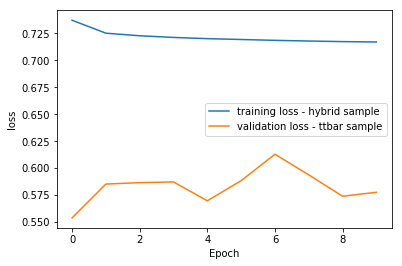

In [14]:
plt.plot(df_results['epoch'],df_results['loss'], label='training loss - hybrid sample')
plt.plot(df_results['epoch'],df_results['val_loss'], label='validation loss - ttbar sample')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

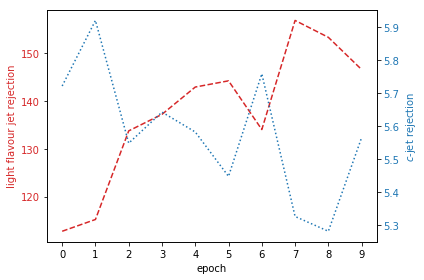

In [15]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('light flavour jet rejection', color=color)
ax1.plot(df_results["epoch"],df_results['u_rej'], '--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$c$-jet rejection', color=color)  # we already handled the x-label with ax1
ax2.plot(df_results["epoch"], df_results['c_rej'], ':', color=color, label='std = 0.12')
ax2.tick_params(axis='y', labelcolor=color)

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()

## Hyper parameter optimisation
You can play with different hyper parameters and see their impact.
The largest impact has the NN-structure itself, you can try changing the number of hidden layers and their number of nodes
Other hyper parameters are the learning rate, activation function, batch size


## Model Evaluation

In [47]:
b_effs = np.linspace(0.39, 1, 150)
l_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('urej')
c_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('crej')

l_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('urej')
c_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('crej')

In [17]:
# To draw the roc curves faster, look at a subset of the test dataset. 
nTest = 50000

/gpfs/slac/atlas/fs1/d/mg294/ml-tutorial/MC16d_ttbar-test-validation_sample-NN.h5
50000/50000 [==============================] - 4s 85us/step
/gpfs/slac/atlas/fs1/d/mg294/ml-tutorial/MC16d_Zprime-test-validation_sample-NN.h5
50000/50000 [==============================] - 4s 84us/step


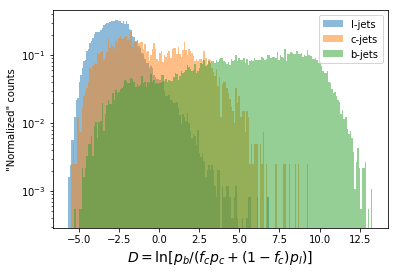

In [19]:
dl1_leffs, dl1_ceffs, dl1_beffs, dl1_discs = [], [], [], []

for testfile_name in [file_path+"/MC16d_ttbar-test-validation_sample-NN.h5",
                      file_path+"/MC16d_Zprime-test-validation_sample-NN.h5"]:
    
    print(testfile_name)
    h5f_test = h5py.File(testfile_name, 'r')

    X_test = h5f_test['X_test'][500000:]
    y_test = h5f_test['Y_test'][500000:]
    
    h5f_test.close()

    (leff, ceff, beff), d = sigBkgEff(model, X_test[:nTest], y_test[:nTest], returnDisc=True, fc=0.018)
     
    dl1_leffs.append(leff)
    dl1_ceffs.append(ceff)
    dl1_beffs.append(beff)
    dl1_discs.append(d)
        

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


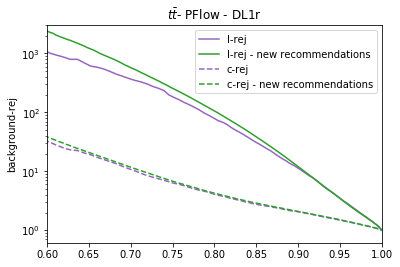

In [42]:
# ttbar
plt.figure()
plt.plot(dl1_beffs[0], 1 / dl1_leffs[0], color='C4', label='l-rej')
plt.plot(b_effs, 1./l_rej, color='C2', label='l-rej - new recommendations')

# plt.figure()
plt.plot(dl1_beffs[0], 1 / dl1_ceffs[0],"--", color='C4', label='c-rej')
plt.plot(b_effs, 1./c_rej, "--", color='C2', label='c-rej - new recommendations')

plt.ylabel('background-rej')

plt.legend()
plt.title(r'$t\bar{t}$- PFlow - DL1r')
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,3000)

plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


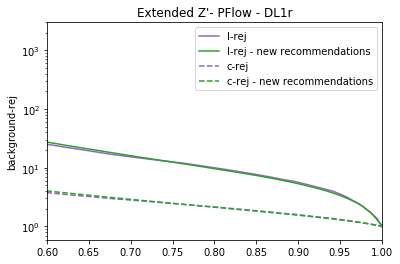

In [51]:
# Z'
plt.figure()
plt.plot(dl1_beffs[1], 1 / dl1_leffs[1], color='C4', label='l-rej')
plt.plot(b_effs, 1./l_rej_Z, color='C2', label='l-rej - new recommendations')

# plt.figure()
plt.plot(dl1_beffs[1], 1 / dl1_ceffs[1],"--", color='C4', label='c-rej')
plt.plot(b_effs, 1./c_rej_Z, "--", color='C2', label='c-rej - new recommendations')

plt.ylabel('background-rej')

plt.legend()
plt.title(r"Extended Z'- PFlow - DL1r")
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,3000)

plt.show()